Initially created by copilot.
GAN, FCN, CIFAR10 RGB images. Ideally needs 200 epochs(!)
to do: convert to CNN

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset # Subset is used to create a subset of the dataset
from torchvision.utils import make_grid # make_grid is used to create a grid of images
import matplotlib.pyplot as plt
import numpy as np

In [14]:
# Data loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load the full dataset
full_dataset = datasets.CIFAR10(root='./data', download=True, transform=transform)

# Create a subset of the first n images
n = 32
subset_dataset = Subset(full_dataset, range(n))

# Now, subset_dataset contains only the first n images from the CIFAR10 dataset.

dataloader = DataLoader(subset_dataset, batch_size=4, shuffle=True)

Files already downloaded and verified


In [4]:
# Define the generator and discriminator networks
class G(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(G, self).__init__()

        self.img_shape = img_shape

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img

class D(nn.Module):
    def __init__(self, img_shape):
        super(D, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

# Hyperparameters
latent_dim = 100
channels = 3
img_size = 32
img_shape = (channels, img_size, img_size)

# Initialize the generator and discriminator
generator = G(latent_dim, img_shape)
discriminator = D(img_shape)

# Loss function and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [18]:
# Training loop


G_loss = [] #initialise losses
D_loss = []

num_epochs = 400
for epoch in range(num_epochs):
    batch_G_loss = [] #initialise losses over batches
    batch_D_loss = []
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = torch.ones(imgs.size(0), 1, requires_grad=False)
        fake = torch.zeros(imgs.size(0), 1, requires_grad=False)

        # Configure input
        real_imgs = imgs.type(torch.FloatTensor)

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = torch.randn(imgs.size(0), latent_dim)
        z = z.type(torch.FloatTensor)

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = criterion(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = criterion(discriminator(real_imgs), valid)
        fake_loss = criterion(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        batch_G_loss.append(g_loss.item())
        batch_D_loss.append(d_loss.item())
        #end of batches loop
    D_loss.append(np.mean(batch_D_loss,axis=0))
    G_loss.append(np.mean(batch_G_loss,axis=0))
    if epoch%10==0 or epoch<=3:
      print(f"[Epoch {epoch}/{num_epochs}] [discrim loss: {round(d_loss.item(),2)}] [gen loss: {round(g_loss.item(),2)}]")
    #end of epoch loop

[Epoch 0/400] [discrim loss: 0.05] [gen loss: 2.52]
[Epoch 1/400] [discrim loss: 0.18] [gen loss: 1.68]
[Epoch 2/400] [discrim loss: 0.1] [gen loss: 1.94]
[Epoch 3/400] [discrim loss: 0.49] [gen loss: 3.9]
[Epoch 10/400] [discrim loss: 0.14] [gen loss: 1.51]
[Epoch 20/400] [discrim loss: 0.11] [gen loss: 1.82]
[Epoch 30/400] [discrim loss: 0.11] [gen loss: 1.72]
[Epoch 40/400] [discrim loss: 0.28] [gen loss: 2.36]
[Epoch 50/400] [discrim loss: 0.27] [gen loss: 2.46]
[Epoch 60/400] [discrim loss: 0.04] [gen loss: 2.64]
[Epoch 70/400] [discrim loss: 0.89] [gen loss: 3.34]
[Epoch 80/400] [discrim loss: 0.05] [gen loss: 2.36]
[Epoch 90/400] [discrim loss: 0.09] [gen loss: 1.96]
[Epoch 100/400] [discrim loss: 0.55] [gen loss: 3.67]
[Epoch 110/400] [discrim loss: 0.18] [gen loss: 2.57]
[Epoch 120/400] [discrim loss: 0.04] [gen loss: 2.64]
[Epoch 130/400] [discrim loss: 0.42] [gen loss: 2.13]
[Epoch 140/400] [discrim loss: 0.13] [gen loss: 1.61]
[Epoch 150/400] [discrim loss: 0.06] [gen loss:

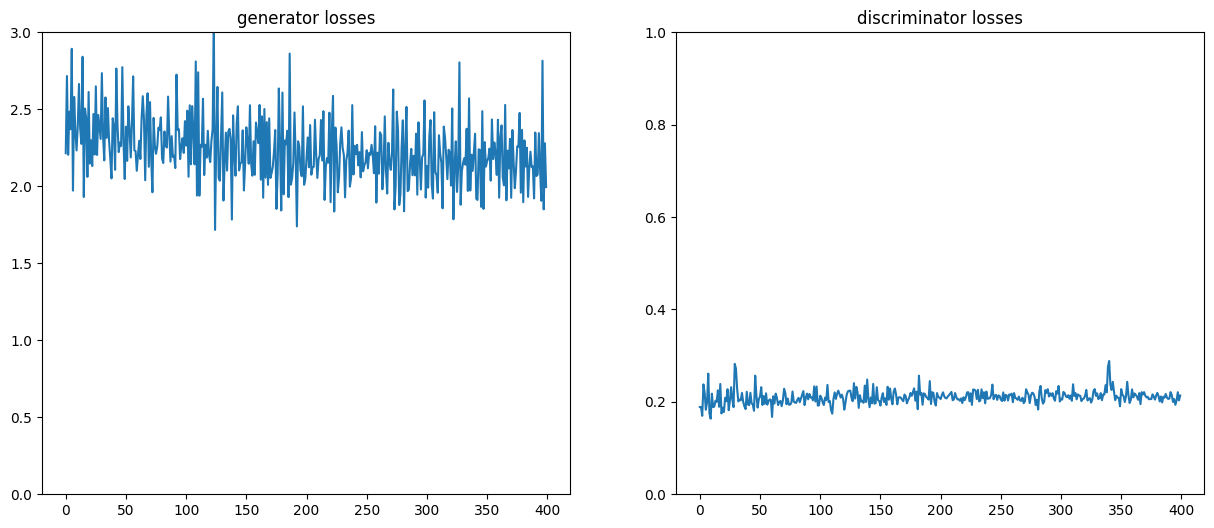

In [19]:
#plot losses
fig, ax = plt.subplots(1,2, figsize=(15, 6)) #note: plt.subplots(rows,cols) but figsize is width/height

ax[0].plot(G_loss)
ax[0].set_ylim([0,3]) # lower,upper limit
ax[0].set_title('generator losses') # replace with your desired title

ax[1].plot(D_loss)
ax[1].set_ylim([0,1]) # replace lower_limit and upper_limit with the desired values
ax[1].set_title('discriminator losses') # replace with your desired title

plt.show()

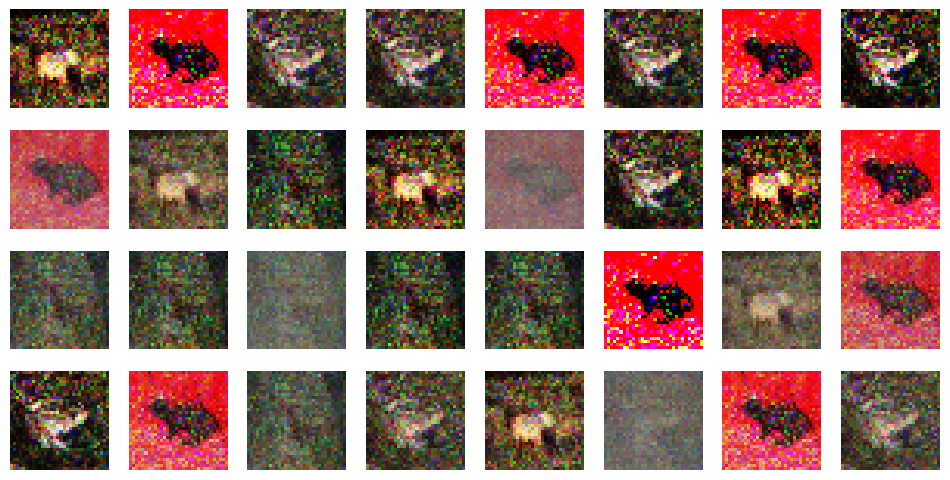

In [20]:
# Generate samples from the trained generator
with torch.no_grad():
    z = torch.randn(32, latent_dim)
    generated_samples = generator(z).view(-1, channels, img_size, img_size).permute(0, 2, 3, 1).cpu().numpy()

# Display generated samples
fig, axes = plt.subplots(4, 8, figsize=(12, 6)) #note: plt.subplots(rows,cols) but figsize is width/height
for i, ax in enumerate(axes.flat):
    ax.imshow((generated_samples[i] + 1) / 2)  # un-normalise to [0, 1]
    ax.axis('off')
plt.show()

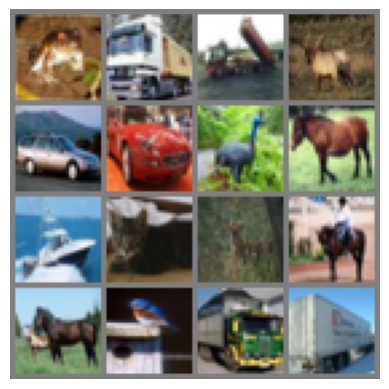

In [10]:
# Create a subset of the first 16 original images
n = 16
subset_dataset = Subset(full_dataset, range(n))

# Create a dataloader for the subset dataset
dataloader_subset = DataLoader(subset_dataset, batch_size=n, shuffle=False)

# Get the first batch of images from the dataloader
images, _ = next(iter(dataloader_subset))

# Create a grid of images
grid = make_grid(images, nrow=4)

# Display the grid of images
plt.imshow((grid.permute(1, 2, 0) + 1) / 2) # un-normalise to [0, 1]
plt.axis('off')
plt.show()
